# Objective

The purpose of this notebook is to build a model able to predict the number of goals a team is going to score
at the next game.

Features are Team plays at home/away, number of goals it scored the last 5 games, during all season so far, the leg, its position, the number of points it has as well as the opponent's rank, number of points, goals conceded last 5 games and number of goals conceded so far.

Then use the probabilities obtained to simulate the last N games of a championship.

In [66]:
import pandas as pd
import numpy as np
import plotly.express as px
from copy import deepcopy

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def rolling_mean_n_performance(df, window=5, performance_col='goals_scored'):
    dg = df.sort_values(by=['leg'])[['season', 'team', performance_col]].groupby(
        by=['season', 'team'])[performance_col].rolling(window=window, min_periods=1).mean().reset_index()
    
    new_col_name = f'rolling_{window}_games_avg_{performance_col}'
    df[new_col_name] = dg.set_index('level_2')[performance_col]
    return df

def get_past_feature(df, feat_col, team=True):

    merge_col = 'team' if team else 'opponent'    
    tmp_df = deepcopy(df[['season', 'leg', merge_col, feat_col]])
    tmp_df.loc[:,'next_leg'] = tmp_df['leg'] +1

    tmp_df.rename(columns={'leg': 'previous_leg', 
                           'next_leg':'leg', 
                           feat_col:f'previous_{merge_col}_{feat_col}'},
                  inplace=True)

    df = df.merge(tmp_df, how='left', on=['leg', 'season', merge_col])
    df.drop(columns=['previous_leg'], inplace=True)
    return df

In [4]:
def prepare_data(csv_path, championship, rolling=5):
    df = pd.read_csv(csv_path).drop(columns='Unnamed: 0')
    df['championship'] = championship
    df['goal_diff'] = df['goals_scored'] - df['goals_conceded']
    # cumulative
    df['cum_pts'] = df[['season', 'team', 'nb_points']].groupby(
    by=['season', 'team']).cumsum()
    
    df['cum_goal_diff'] = df[['season', 'team', 'goal_diff']].groupby(
    by=['season', 'team']).cumsum()
    
    df['cum_goals_scored'] = df[['season', 'team', 'goals_scored']].groupby(
    by=['season', 'team']).cumsum()
    
    df['cum_goals_conceded'] = df['cum_goals_scored']-df['cum_goal_diff']
    df['rank'] = df[['season', 'leg', 'cum_pts', 'cum_goal_diff', 'cum_goals_scored']].sort_values(
        by=['cum_pts', 'cum_goal_diff', 'cum_goals_scored'], ascending=False).groupby(
        by=['season', 'leg']).cumcount() + 1
    
    df['avg_goals_scored_since_season_start'] = df['cum_goals_scored'].div(df['leg'])
    df['avg_goals_conceded_since_season_start'] = df['cum_goals_conceded'].div(df['leg'])
    df['avg_cum_pts_since_season_start'] = df['cum_pts'].div(df['leg'])
    
    # removed unwanted useless seasons
    data = deepcopy(df[df.season > '2003-2004'])
    data.reset_index(drop=True, inplace=True)
    
    leg_max = data.leg.max()
    
    end_season = data[data.leg==leg_max].rename(columns={'rank':'final_rank', 'cum_pts': 'final_cum_pts'})
    data = data.merge(end_season[['season', 'team', 'final_rank', 'final_cum_pts']], on=['season', 'team'])
    
    # rolling mean
    cols = ['goals_conceded', 'goals_scored', 'nb_points']
    for c in cols:
        data = rolling_mean_n_performance(df=data, window=rolling, performance_col=c)
    # past features
    past_features = {'rank': [True, False], 
                     'rolling_5_games_avg_goals_scored' : [True],
                     'rolling_5_games_avg_goals_conceded': [False],
                     'avg_goals_scored_since_season_start': [True],
                     'avg_goals_conceded_since_season_start': [False],
                     'goals_scored': [True],
                     'goals_conceded': [False],
                     'rolling_5_games_avg_nb_points': [True, False],
                     'nb_points': [True, False]
                    }
    # print(f'length {len(data)}')
    for col, is_team_ll in past_features.items():
        for is_team in is_team_ll:
            # print(f"is_team ={is_team}, col = {col}")
            data = get_past_feature(df=data, feat_col=col, team=is_team)
    
    return data

In [5]:
def get_pivoted(data: pd.DataFrame, break_leg: int, value_col: str = 'goals_scored'):
    
    df = deepcopy(data[data.leg <= break_leg])
    df.rolling_5_games_avg_nb_points = [y if x!=x else x for x, y in 
           zip(df.rolling_5_games_avg_nb_points, df.avg_cum_pts_since_season_start)]
    
    df_pivot = df.pivot_table(index=['season', 'team'], 
                              columns='leg', 
                              values=[value_col]).reset_index()
    
    df_pivot.columns = [f'leg_{l}' if l!='' else n for n, l in df_pivot.columns]
    
    final = df[['season', 'team', 'final_rank', 'final_cum_pts']].drop_duplicates()
    df_last_leg = df[df.leg==break_leg][['season', 
                                          'team', 
                                          'rank', 
                                          'rolling_5_games_avg_nb_points', 
                                          'avg_cum_pts_since_season_start', 
                                          'cum_pts']].reset_index(drop=True)
    
    df_pivot = df_pivot.merge(df_last_leg, on=['season', 'team'])
    
    return df_pivot.merge(final, on=['season', 'team'])

In [6]:
# hist on goal scored

In [7]:
def hist_aggregator(df, column_to_describe, aggreg_column=None, bin_step=None):
    aggreg_column = column_to_describe if aggreg_column is None else aggreg_column
    if bin_step is not None:
        df[f'{aggreg_column}_binned'] = df[aggreg_column].apply(lambda x : (x//bin_step)*bin_step)
        aggreg_column = f'{aggreg_column}_binned'
    
    feats = list({aggreg_column, column_to_describe})
    df_agg = df[feats+['championship']].groupby(
        by=feats).count().reset_index()
    df_agg.rename(columns={'championship': 'cnt'}, inplace=True)
    return df_agg

def mean_aggregator(df, column_to_describe, aggreg_column='play', bin_step=None):
    if bin_step is not None:
        df[f'{aggreg_column}_binned'] = df[aggreg_column].apply(lambda x : (x//bin_step)*bin_step)
        aggreg_column = f'{aggreg_column}_binned'
        
    df_agg = df[[aggreg_column, column_to_describe]].groupby(
        by=[aggreg_column]).mean().reset_index()
    df_agg.rename(columns={column_to_describe: f'avg_{column_to_describe}'}, inplace=True)
    
    
    df_cnt = df[[aggreg_column, column_to_describe]].groupby(
        by=[aggreg_column]).count().reset_index()
    df_cnt.rename(columns={column_to_describe: 'cnt'}, inplace=True)
    
    return df_agg.merge(df_cnt, how='left', on=aggreg_column)

In [8]:
# scatterplot on hist : change to hist bar
def draw_scatterplot(df, x, y, size_col, title):
    fig = px.scatter(df, x=x, y=y, size=size_col, title=title)
    fig.show()


# line on mean
def draw_line(df, x, y, title):
    fig = px.line(df, x=x, y=y, title=title)
    fig.show()

In [9]:
# Preprocessing

In [10]:
championship_csv = {'ligue-1': 'ligue-1_data_2002_2019',
                   'ligue-2': 'ligue-2_data_2002_2019',
                   'serie-A': 'serie-a_data_2004_2019',
                   'bundesliga': 'bundesliga_data_2004_2019',
                   'premier-league': 'premier-league_data_2004_2019',
                   'liga':'liga_data_2004_2019'}

In [11]:
data_df = prepare_data(championship_csv['ligue-1'], championship='ligue-1')

In [12]:
all_data_dfs = [prepare_data(csv_path=path, championship=champ) for champ, path in championship_csv.items()]

In [13]:
all_data_df = pd.concat(all_data_dfs)

In [14]:
data_exploitable_df = deepcopy(all_data_df[all_data_df.leg > 1]).reset_index()

In [15]:
#data_df.head()

In [16]:
data_exploitable_df.head()

index country     season  leg  team  play  goals_scored opponent  \
0      1  France  2004-2005    2  Lyon  Home             1  Sochaux   
1      2  France  2004-2005    3  Lyon  Away             1     Metz   
2      3  France  2004-2005    4  Lyon  Home             1    Lille   
3      4  France  2004-2005    5  Lyon  Away             2   Rennes   
4      5  France  2004-2005    6  Lyon  Home             0   Bastia   

   goals_conceded  nb_points  ...  \
0               1          1  ...   
1               1          1  ...   
2               0          3  ...   
3               1          3  ...   
4               0          1  ...   

  previous_team_rolling_5_games_avg_goals_scored  \
0                                       0.000000   
1                                       0.500000   
2                                       0.666667   
3                                       0.750000   
4                                       1.000000   

   previous_opponent_rolling_5_games_avg_goals_conceded  \
0                                           1.000000      
1                                           1.500000      
2                                           1.333333      
3                                           1.250000      
4                                           1.200000      

   previous_team_avg_goals_scored_since_season_start  \
0                                           0.000000   
1                                           0.500000   
2                                           0.666667   
3                                           0.750000   
4                                           1.000000   

   previous_opponent_avg_goals_conceded_since_season_start  \
0                                           1.000000         
1                                           1.500000         
2                                           1.333333         
3                                           1.250000         
4                                           1.200000         

   previous_team_goals_scored  previous_opponent_goals_conceded  \
0                         0.0                               1.0   
1                         1.0                               2.0   
2                         1.0                               0.0   
3                         1.0                               1.0   
4                         2.0                               1.0   

   previous_team_rolling_5_games_avg_nb_points  \
0                                          1.0   
1                                          1.0   
2                                          1.0   
3                                          1.5   
4                                          1.8   

   previous_opponent_rolling_5_games_avg_nb_points  previous_team_nb_points  \
0                                         3.000000                      1.0   
1                                         1.500000                      1.0   
2                                         1.666667                      1.0   
3                                         1.000000                      3.0   
4                                         1.800000                      3.0   

   previous_opponent_nb_points  
0                          3.0  
1                          0.0  
2                          1.0  
3                          1.0  
4                          0.0  

[5 rows x 37 columns]

In [65]:
team_last5_perf_on_goals_hist = hist_aggregator(df=data_exploitable_df, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_rolling_5_games_avg_goals_scored',
                bin_step=.1)

team_last5_perf_on_goals_mean = mean_aggregator(df=data_exploitable_df, 
                column_to_describe='goals_scored', 
                aggreg_column='previous_team_rolling_5_games_avg_goals_scored',
                bin_step=.1)

In [66]:
draw_scatterplot(df=team_last5_perf_on_goals_hist,
                 x='previous_team_rolling_5_games_avg_goals_scored_binned',
                 y='goals_scored',
                 size_col='cnt',
                 title='5 leg Avg on Team goals scored vs goals to be scored')

In [62]:
draw_line(df=team_last5_perf_on_goals_mean,
          x='previous_team_rolling_5_games_avg_goals_scored_binned',
          y='avg_goals_scored',
          title='5 leg Avg on Team goals scored vs avg goals to be scored')

In [63]:
team_last5_perf_on_goals_mean

previous_team_rolling_5_games_avg_goals_scored_binned  avg_goals_scored  \
0                                                 0.0              1.165327   
1                                                 0.2              1.066132   
2                                                 0.3              1.113333   
3                                                 0.4              1.107232   
4                                                 0.5              1.130800   
5                                                 0.6              1.135714   
6                                                 0.7              1.100806   
7                                                 0.8              1.164313   
8                                                 0.9              1.206819   
9                                                 1.1              1.237026   
10                                                1.2              1.167832   
11                                                1.3              1.295604   
12                                                1.4              1.243007   
13                                                1.6              1.370902   
14                                                1.7              1.389202   
15                                                1.9              1.462838   
16                                                2.2              1.567511   
17                                                2.3              1.762737   
18                                                2.4              1.466292   
19                                                2.5              1.888069   
20                                                2.6              1.606557   
21                                                2.7              1.960591   
22                                                2.9              1.811159   
23                                                3.2              2.101215   
24                                                3.3              2.086420   
25                                                3.4              1.520833   
26                                                3.5              2.445545   
27                                                3.6              2.500000   
28                                                3.7              2.533333   
29                                                3.9              1.861789   
30                                                4.1              2.653846   
31                                                4.2              2.500000   
32                                                4.3              2.000000   
33                                                4.4              2.470588   
34                                                4.5              2.800000   
35                                                4.6              0.000000   
36                                                4.7              3.250000   
37                                                4.9              1.807692   
38                                                5.1              2.000000   
39                                                5.4              2.000000   
40                                                5.9              1.125000   
41                                                6.9              1.333333   
42                                                7.9              1.333333   

     cnt  
0    871  
1    998  
2    150  
3   3208  
4   5000  
5    280  
6    248  
7   7151  
8   9825  
9   8016  
10   286  
11  7280  
12   572  
13  5918  
14  4260  
15  3848  
16  1896  
17  1374  
18   178  
19   813  
20    61  
21   609  
22   699  
23   247  
24   162  
25    48  
26   101  
27    14  
28    75  
29   123  
30    26  
31     2  
32     2  
33    17  
34     5  
35     1  
36     4  
37    26  
38     1  
39     1  
40     8  
41     3  
42     3

##  Class analysis

In [78]:
dg = data_exploitable_df[['championship', 'goals_scored', 'play']].groupby(
    by=['championship', 'goals_scored']).count()
dg.reset_index(inplace=True)
dg.rename(columns={'play': 'quantity'}, inplace=True)
total = data_exploitable_df[['championship', 'play']].groupby(by=['championship']).count()
total.reset_index(inplace=True)
total.rename(columns={'play': 'total'}, inplace=True)
class_recap = dg.merge(total, how='left', on='championship')
class_recap['percent'] = 100*class_recap['quantity'].div(class_recap['total'])
class_recap

championship  goals_scored  quantity  total    percent
0       bundesliga             0      2281   8910  25.600449
1       bundesliga             1      2948   8910  33.086420
2       bundesliga             2      2024   8910  22.716049
3       bundesliga             3      1043   8910  11.705948
4       bundesliga             4       410   8910   4.601571
5       bundesliga             5       134   8910   1.503928
6       bundesliga             6        55   8910   0.617284
7       bundesliga             7         9   8910   0.101010
8       bundesliga             8         5   8910   0.056117
9       bundesliga             9         1   8910   0.011223
10            liga             0      3144  11100  28.324324
11            liga             1      3710  11100  33.423423
12            liga             2      2441  11100  21.990991
13            liga             3      1109  11100   9.990991
14            liga             4       457  11100   4.117117
15            liga             5       165  11100   1.486486
16            liga             6        51  11100   0.459459
17            liga             7        14  11100   0.126126
18            liga             8         7  11100   0.063063
19            liga             9         1  11100   0.009009
20            liga            10         1  11100   0.009009
21         ligue-1             0      3456  11100  31.135135
22         ligue-1             1      3918  11100  35.297297
23         ligue-1             2      2301  11100  20.729730
24         ligue-1             3       969  11100   8.729730
25         ligue-1             4       329  11100   2.963964
26         ligue-1             5        92  11100   0.828829
27         ligue-1             6        26  11100   0.234234
28         ligue-1             7         4  11100   0.036036
29         ligue-1             8         3  11100   0.027027
30         ligue-1             9         2  11100   0.018018
31         ligue-2             0      3444  11100  31.027027
32         ligue-2             1      4006  11100  36.090090
33         ligue-2             2      2384  11100  21.477477
34         ligue-2             3       894  11100   8.054054
35         ligue-2             4       293  11100   2.639640
36         ligue-2             5        58  11100   0.522523
37         ligue-2             6        20  11100   0.180180
38         ligue-2             7         1  11100   0.009009
39  premier-league             0      3208  11100  28.900901
40  premier-league             1      3671  11100  33.072072
41  premier-league             2      2421  11100  21.810811
42  premier-league             3      1159  11100  10.441441
43  premier-league             4       442  11100   3.981982
44  premier-league             5       133  11100   1.198198
45  premier-league             6        47  11100   0.423423
46  premier-league             7        13  11100   0.117117
47  premier-league             8         5  11100   0.045045
48  premier-league             9         1  11100   0.009009
49         serie-A             0      3107  11100  27.990991
50         serie-A             1      3795  11100  34.189189
51         serie-A             2      2483  11100  22.369369
52         serie-A             3      1175  11100  10.585586
53         serie-A             4       397  11100   3.576577
54         serie-A             5       115  11100   1.036036
55         serie-A             6        19  11100   0.171171
56         serie-A             7         9  11100   0.081081

Notes :

- remove rows where number of goals is >= 5 

- predict of a team scores < 5 goals or more

# Xgboost classifier

In [17]:
from xgboost import XGBRFClassifier, XGBClassifier

In [18]:
from collections import Counter

In [19]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [23]:
from sklearn.preprocessing import MinMaxScaler

#### data prep

In [24]:
no_use_cols = ['index', 'country', 'season', 'team', 'opponent', 
               'previous_team_rolling_5_games_avg_goals_scored_binned']
usable_cols = [c for c in data_exploitable_df.columns if c not in no_use_cols]
usable_cols = ['leg', 'play'] + [c for c in usable_cols if c.startswith('previous')] + ['goals_scored']

In [25]:
classifier_data_df = deepcopy(data_exploitable_df.loc[:,usable_cols])

In [26]:
classifier_data_df = deepcopy(classifier_data_df[classifier_data_df.goals_scored < 5])

In [27]:
classifier_data_df

leg  play  previous_team_rank  previous_opponent_rank  \
0        2  Home                12.0                     2.0   
1        3  Away                14.0                     8.0   
2        4  Home                15.0                     4.0   
3        5  Away                 6.0                    13.0   
4        6  Home                 4.0                     5.0   
...    ...   ...                 ...                     ...   
64405   34  Away                 1.0                    18.0   
64406   35  Home                 1.0                     8.0   
64407   36  Away                 1.0                    12.0   
64408   37  Home                 1.0                    18.0   
64409   38  Away                 1.0                    14.0   

       previous_team_rolling_5_games_avg_goals_scored  \
0                                            0.000000   
1                                            0.500000   
2                                            0.666667   
3                                            0.750000   
4                                            1.000000   
...                                               ...   
64405                                        2.000000   
64406                                        2.000000   
64407                                        1.400000   
64408                                        1.000000   
64409                                        1.400000   

       previous_opponent_rolling_5_games_avg_goals_conceded  \
0                                               1.000000      
1                                               1.500000      
2                                               1.333333      
3                                               1.250000      
4                                               1.200000      
...                                                  ...      
64405                                           1.600000      
64406                                           2.400000      
64407                                           1.000000      
64408                                           1.200000      
64409                                           1.000000      

       previous_team_avg_goals_scored_since_season_start  \
0                                               0.000000   
1                                               0.500000   
2                                               0.666667   
3                                               0.750000   
4                                               1.000000   
...                                                  ...   
64405                                           2.484848   
64406                                           2.470588   
64407                                           2.428571   
64408                                           2.361111   
64409                                           2.351351   

       previous_opponent_avg_goals_conceded_since_season_start  \
0                                               1.000000         
1                                               1.500000         
2                                               1.333333         
3                                               1.250000         
4                                               1.200000         
...                                                  ...         
64405                                           1.484848         
64406                                           1.352941         
64407                                           1.114286         
64408                                           1.416667         
64409                                           1.351351         

       previous_team_goals_scored  previous_opponent_goals_conceded  \
0                             0.0                               1.0   
1                             1.0                               2.0   
2                             1.0                               0.0  

In [28]:
# encode play variable
classifier_data_df['play'] = [1 if p=='Home' else 0 for p in classifier_data_df.play]

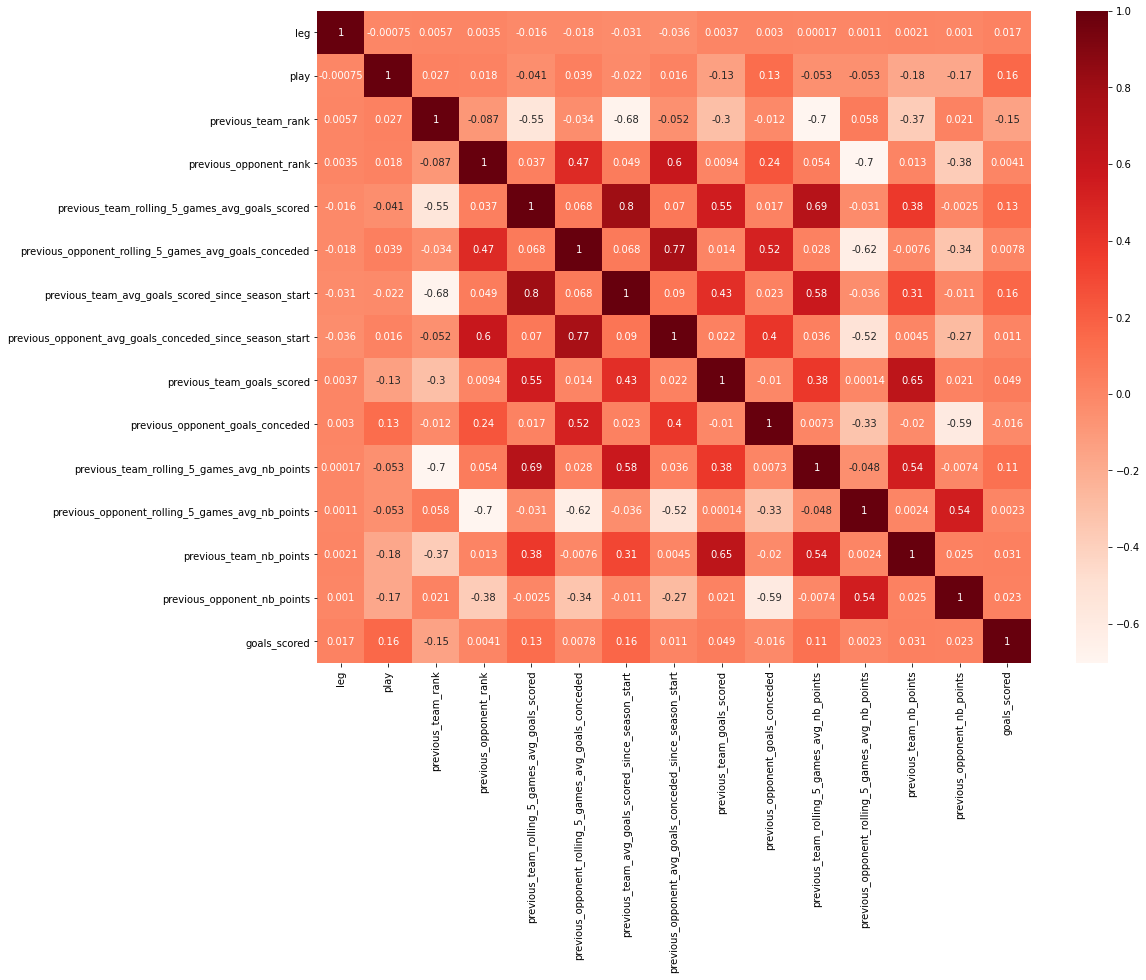

In [29]:
# correlation plot
cor = classifier_data_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [30]:
cor['goals_scored']

leg                                                        0.017414
play                                                       0.158763
previous_team_rank                                        -0.148199
previous_opponent_rank                                     0.004114
previous_team_rolling_5_games_avg_goals_scored             0.128715
previous_opponent_rolling_5_games_avg_goals_conceded       0.007838
previous_team_avg_goals_scored_since_season_start          0.164106
previous_opponent_avg_goals_conceded_since_season_start    0.011130
previous_team_goals_scored                                 0.049013
previous_opponent_goals_conceded                          -0.015817
previous_team_rolling_5_games_avg_nb_points                0.110063
previous_opponent_rolling_5_games_avg_nb_points            0.002313
previous_team_nb_points                                    0.031073
previous_opponent_nb_points                                0.022711
goals_scored                                    

In [31]:
# split train-test-valid : 0.8x.95-0.2x.95-0.05
features_data = classifier_data_df.drop('goals_scored', axis=1).values
target_data = classifier_data_df['goals_scored'].values

In [32]:
mm_scaler = MinMaxScaler(feature_range=(0,100))

In [33]:
scale = False

In [34]:
if scale:
    feature_data = mm_scaler.fit_transform(features_data)

In [35]:
X_model, X_valid, y_model, y_valid = train_test_split(features_data, 
                                                      target_data, 
                                                      test_size=0.05, 
                                                      random_state=42,
                                                      stratify=target_data
                                                     )

X_train, X_test, y_train, y_test = train_test_split(X_model,
                                                    y_model,
                                                    test_size=.2,
                                                    random_state=61,
                                                    stratify=y_model
                                                   )

In [36]:
oversampler = SMOTE(random_state=42) #RandomOverSampler()

In [37]:
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

In [38]:
len(y_train_over)

83785

In [39]:
len(y_train)

48198

In [40]:
Counter(y_test)

Counter({2: 2670, 0: 3542, 1: 4189, 3: 1206, 4: 443})

#### Models 

In [ ]:
def get_model(model_name:str, X, y):
    """
    model_name: str: name of the model to be used. MUST be in 
    ['xgboost', 'random_forest', 'decision_tree', 'extra_tree']
    X: array-like : feature
    y: array-like : target
    
    returns: fitted model 
    """

In [41]:
xgb_class = XGBClassifier()

In [42]:
rf_class = RandomForestClassifier(random_state=42)

In [43]:
extra_tree_class = ExtraTreesClassifier(random_state=42)

In [44]:
decision_tree_class = DecisionTreeClassifier(random_state=42)

In [45]:
xgb_class.fit(X=X_train_over, y=y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
rf_class.fit(X=X_train_over, y=y_train_over)

RandomForestClassifier(random_state=42)

In [47]:
extra_tree_class.fit(X=X_train_over, y=y_train_over)

ExtraTreesClassifier(random_state=42)

In [48]:
decision_tree_class.fit(X=X_train_over, y=y_train_over)

DecisionTreeClassifier(random_state=42)

In [49]:
xgb_predictions = xgb_class.predict(X_test)

In [50]:
rf_predictions = rf_class.predict(X_test)

In [51]:
extra_tree_predictions = extra_tree_class.predict(X_test)

In [52]:
decision_tree_predictions = decision_tree_class.predict(X_test)

In [53]:
# Counter(xgb_predictions)

In [54]:
# Counter(y_test)

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [56]:
confusion_matrix(y_true=y_test, y_pred=xgb_predictions)

array([[1224, 1992,  275,   35,   16],
       [1262, 2398,  431,   82,   16],
       [ 669, 1605,  313,   67,   16],
       [ 233,  717,  182,   57,   17],
       [  74,  251,   82,   29,    7]])

In [57]:
confusion_matrix(y_true=y_test, y_pred=rf_predictions)

array([[1399, 1604,  434,   81,   24],
       [1444, 1946,  636,  130,   33],
       [ 797, 1253,  472,  115,   33],
       [ 297,  581,  237,   67,   24],
       [ 101,  186,  112,   34,   10]])

In [58]:
confusion_matrix(y_true=y_test, y_pred=extra_tree_predictions)

array([[1375, 1628,  438,   86,   15],
       [1425, 1909,  665,  147,   43],
       [ 805, 1219,  489,  105,   52],
       [ 291,  572,  231,   76,   36],
       [  91,  192,  113,   34,   13]])

In [59]:
confusion_matrix(y_true=y_test, y_pred=decision_tree_predictions)

array([[1116, 1177,  751,  356,  142],
       [1194, 1391,  947,  476,  181],
       [ 774,  805,  644,  328,  119],
       [ 286,  386,  299,  163,   72],
       [ 110,  139,   98,   65,   31]])

In [60]:
accuracy_score(y_true=y_test, y_pred=xgb_predictions)

0.33186721991701246

In [61]:
accuracy_score(y_true=y_test, y_pred=rf_predictions)

0.32315352697095434

In [62]:
accuracy_score(y_true=y_test, y_pred=extra_tree_predictions)

0.3204979253112033

In [63]:
accuracy_score(y_true=y_test, y_pred=decision_tree_predictions)

0.27759336099585064

In [ ]:
for c, fi in zip(usable_cols, xgb_class.feature_importances_):
    print(f"importance of {c} : {fi}")

In [ ]:
for c, fi in zip(usable_cols,rf_class.feature_importances_):
    print(f"importance of {c} : {fi}")

In [ ]:
for c, fi in zip(usable_cols,extra_tree_class.feature_importances_):
    print(f"importance of {c} : {fi}")

In [236]:
usable_cols = [# 'leg', 
               'play', 'previous_team_nb_points', 'previous_opponent_rolling_5_games_avg_nb_points',
        'previous_opponent_avg_goals_conceded_since_season_start',
       'previous_team_goals_scored',  'previous_opponent_rank', 
         'previous_team_rolling_5_games_avg_goals_scored'
              ] + ['goals_scored']

In [319]:
len(X_train)

48198

In [344]:
X_train[0]

array([2.16440000e+04, 1.00000000e+00, 3.00000000e+00, 2.60000000e+00,
       1.13513514e+00, 1.00000000e+00, 1.10000000e+01, 8.00000000e-01])

# Visualize input space

In [316]:
from umap import UMAP

In [317]:
reducer = UMAP()

In [320]:
embedding_umap = reducer.fit_transform(X_train)

In [321]:
import plotly.express as px
umap_df = pd.DataFrame(embedding_umap, columns=['x', 'y'])
umap_df['label'] = y_train
fig = px.scatter(umap_df,
                 x="x", y="y", color="label")
fig.show()